In [1]:
from typing import Annotated, TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import AnyMessage, AIMessage, BaseMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from dotenv import load_dotenv


c:\Codes\Learning\Lang_graph\venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [5]:
load_dotenv()


True

In [6]:
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")


In [7]:
res = llm.invoke("hi")
print(res)

content='Hi there! How can I help you today?' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'} id='lc_run--6224965f-b720-46a2-8c9f-6d3e50ea7fc6-0' usage_metadata={'input_tokens': 2, 'output_tokens': 36, 'total_tokens': 38, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 26}}


In [8]:
class ChatState(TypedDict):
  messages: Annotated[list[BaseMessage],add_messages]
  

In [10]:
def chat_node(state: ChatState):

    decision = interrupt({
        "type": "approval",
        "reason": "Model is about to answer a user question.",
        "question": state["messages"][-1].content,
        "instruction": "Approve this question? yes/no"
    })
    
    if decision["approved"] == 'no':
        return {"messages": [AIMessage(content="Not approved.")]}

    else:
        response = llm.invoke(state["messages"])
        return {"messages": [response]}

In [11]:
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)

builder.add_edge(START, "chat")
builder.add_edge("chat", END)

# Checkpointer is required for interrupts
checkpointer = MemorySaver()

# Compile the app
app = builder.compile(checkpointer=checkpointer)

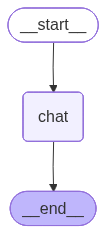

In [12]:
app

In [19]:
config = {"configurable": {"thread_id": '1234'}}

initial_input = {
    "messages": [
        ("user", "Explain gradient descent in very simple terms.")
    ] 
}

result = app.invoke(initial_input, config=config)

In [20]:
result

{'messages': [HumanMessage(content='Explain gradient descent in very simple terms.', additional_kwargs={}, response_metadata={}, id='171f2103-4238-48a6-a911-e667e5759b8a'),
  AIMessage(content='Not approved.', additional_kwargs={}, response_metadata={}, id='a3dd67a4-00d9-4114-8163-680ee9ed33a9'),
  HumanMessage(content='Explain gradient descent in very simple terms.', additional_kwargs={}, response_metadata={}, id='b97451fd-e15d-4b92-b91c-53db67e56002')],
 '__interrupt__': [Interrupt(value={'type': 'approval', 'reason': 'Model is about to answer a user question.', 'question': 'Explain gradient descent in very simple terms.', 'instruction': 'Approve this question? yes/no'}, id='93ba427e2b4b590606e05687b1291ba8')]}

In [21]:
message = result['__interrupt__'][0].value
message

{'type': 'approval',
 'reason': 'Model is about to answer a user question.',
 'question': 'Explain gradient descent in very simple terms.',
 'instruction': 'Approve this question? yes/no'}

In [22]:
user_input = input(f"\nBackend message - {message} \n Approve this question? (y/n): ")


In [23]:
final_result = app.invoke(
    Command(resume={"approved": user_input}),
    config=config,
)

In [24]:
print(final_result["messages"][-1].content)

Imagine you're **blindfolded** and standing somewhere on a **hilly landscape**. Your goal is to find the **lowest point in the valley** (where the error is minimized) without being able to see anything.

Here's how Gradient Descent works, step-by-step:

1.  **Feel the Slope (The "Gradient"):** You can't see the whole valley, but you can feel the ground right where you are. You can tell which way is downhill and how steep it is. This "feeling the slope" is what we call calculating the **gradient**.

2.  **Take a Step Downhill (The "Descent"):** Based on which way feels steepest downhill, you take a small step in that direction.

3.  **Repeat:** You keep repeating steps 1 and 2:
    *   Feel the slope again from your new position.
    *   Take another small step downhill.

4.  **Adjust Step Size (The "Learning Rate"):**
    *   If your steps are too big, you might jump over the lowest point, or even go up the other side of a small dip.
    *   If your steps are too small, it will take yo